**Heart Disease Prediction**
*Made by: Alex, Léonard et Océan*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.svm import SVC
from joblib import dump, load
import ast
%matplotlib inline

**Data loading**

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_disease_data = heart_disease.data.features 
target = heart_disease.data.targets 
print(heart_disease_data, target)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3.0   3.0  
2        2  2.0

In [4]:
def map_target_values(value):
    if value > 0:
        return 1
    else:
        return 0

# Apply the function to the target column
target = target['num'].map(map_target_values)
target = target.rename('illness')
target.to_csv('target.csv')
print(target)

0      0
1      1
2      1
3      0
4      0
      ..
298    1
299    1
300    1
301    1
302    0
Name: illness, Length: 303, dtype: int64


In [5]:
target.value_counts()

illness
0    164
1    139
Name: count, dtype: int64

In [6]:
heart_disease_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


In [7]:
heart_disease_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


**Data formatting and cleaning**

*Renaming the columns with more meaningful names*

In [8]:
# Define a dictionary for renaming the columns
renaming_dict = {
    'age': 'age',
    'sex': 'gender',
    'cp': 'chest_pain_type',
    'trestbps': 'resting_blood_pressure',
    'chol': 'serum_cholesterol_mg_per_dl',
    'fbs': 'fasting_blood_sugar_gt_120_mg_per_dl',
    'restecg': 'resting_ecg_results',
    'thalach': 'maximum_heart_rate_achieved',
    'exang': 'exercise_induced_angina',
    'oldpeak': 'st_depression_induced_by_exercise_relative_to_rest',
    'slope': 'slope_of_peak_exercise_st_segment',
    'ca': 'number_of_major_vessels_colored_by_flourosopy',
    'thal': 'thalassemia',
}

# Code to rename the columns
heart_disease_data_renamed = heart_disease_data.rename(columns=renaming_dict)

*Checking for missing values*

In [9]:
heart_disease_data_renamed.isnull().sum()

age                                                   0
gender                                                0
chest_pain_type                                       0
resting_blood_pressure                                0
serum_cholesterol_mg_per_dl                           0
fasting_blood_sugar_gt_120_mg_per_dl                  0
resting_ecg_results                                   0
maximum_heart_rate_achieved                           0
exercise_induced_angina                               0
st_depression_induced_by_exercise_relative_to_rest    0
slope_of_peak_exercise_st_segment                     0
number_of_major_vessels_colored_by_flourosopy         4
thalassemia                                           2
dtype: int64

In [10]:
# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values using K-Nearest Neighbors
heart_disease_data_imputed = pd.DataFrame(imputer.fit_transform(heart_disease_data_renamed),                                      columns=heart_disease_data_renamed.columns)

# Check if there are any missing values left
missing_values_after_imputation = heart_disease_data_imputed.isnull().sum()

missing_values_after_imputation


age                                                   0
gender                                                0
chest_pain_type                                       0
resting_blood_pressure                                0
serum_cholesterol_mg_per_dl                           0
fasting_blood_sugar_gt_120_mg_per_dl                  0
resting_ecg_results                                   0
maximum_heart_rate_achieved                           0
exercise_induced_angina                               0
st_depression_induced_by_exercise_relative_to_rest    0
slope_of_peak_exercise_st_segment                     0
number_of_major_vessels_colored_by_flourosopy         0
thalassemia                                           0
dtype: int64

In [11]:
heart_disease_data_imputed.head(303)

,age,gender,chest_pain_type,resting_blood_pressure,serum_cholesterol_mg_per_dl,fasting_blood_sugar_gt_120_mg_per_dl,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise_relative_to_rest,slope_of_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,thalassemia
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0


## Preprocessing

In [12]:
# Identify categorical and numerical columns
numerical_cols = [
    'age', 
    'resting_blood_pressure', 
    'serum_cholesterol_mg_per_dl', 
    'maximum_heart_rate_achieved', 
    'st_depression_induced_by_exercise_relative_to_rest', 
    'number_of_major_vessels_colored_by_flourosopy'
]

categorical_cols = [
    'gender', 
    'chest_pain_type', 
    'fasting_blood_sugar_gt_120_mg_per_dl', 
    'resting_ecg_results', 
    'exercise_induced_angina', 
    'slope_of_peak_exercise_st_segment', 
    'thalassemia'
]

# Create a transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)  
    ]
)

# Apply transformations to the dataset
heart_disease_data_preprocessed = preprocessor.fit_transform(heart_disease_data_imputed)
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + onehot_feature_names.tolist()
heart_disease_data_preprocessed = pd.DataFrame(heart_disease_data_preprocessed, columns=feature_names)


## Saving the preprocessor

In [13]:
dump(preprocessor, 'heart_disease_preprocessor.joblib')

['heart_disease_preprocessor.joblib']

## Data Visualization

In [14]:
# Concatenate the features and target to form a complete dataset
target_series = pd.Series(target)
complete_data = pd.concat([heart_disease_data_imputed, target_series], axis=1)
complete_data.head()

,age,gender,chest_pain_type,resting_blood_pressure,serum_cholesterol_mg_per_dl,fasting_blood_sugar_gt_120_mg_per_dl,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise_relative_to_rest,slope_of_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,thalassemia,illness
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [15]:
complete_data.to_csv('heart_disease.csv', index=False)

## Histograms

Histograms provide a visual representation of the distribution of the data. We will plot histograms for each variable, using color to distinguish between patients with and without heart disease.

### Analysis
- These histograms will help us understand the distribution of each variable.
- By comparing the distributions for patients with and without heart disease, we can identify any notable differences.



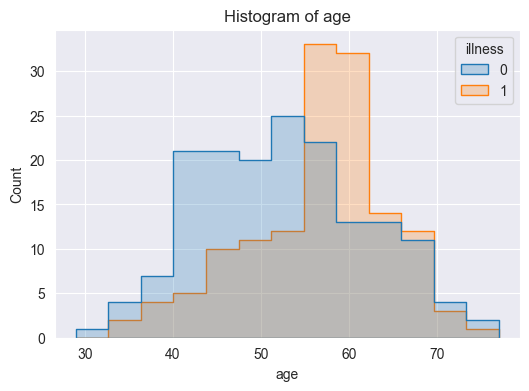

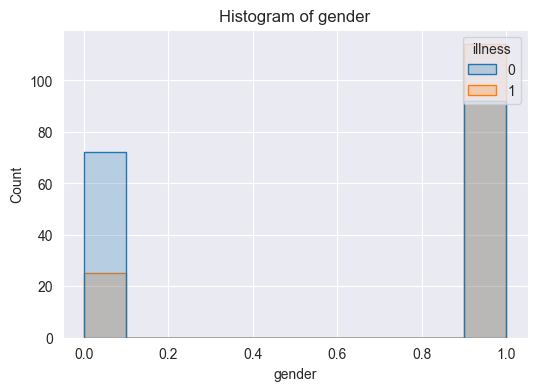

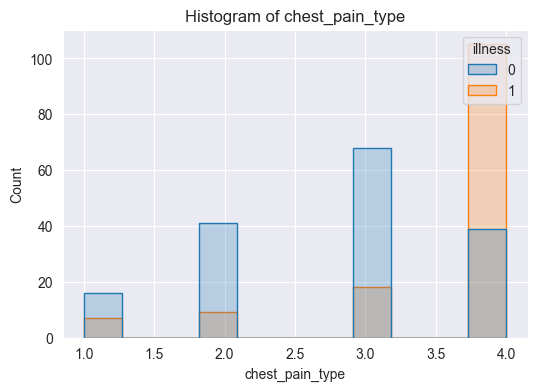

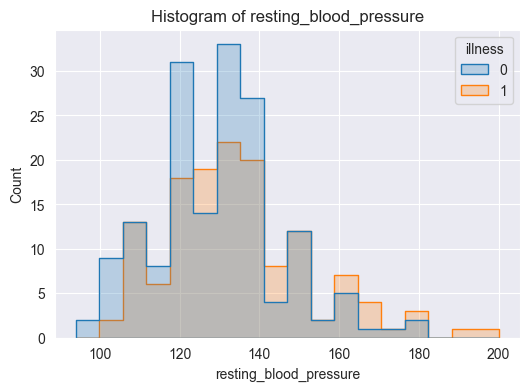

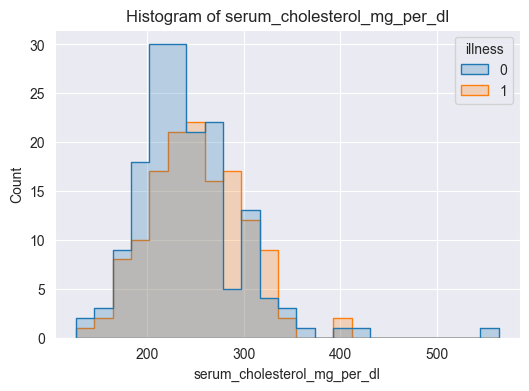

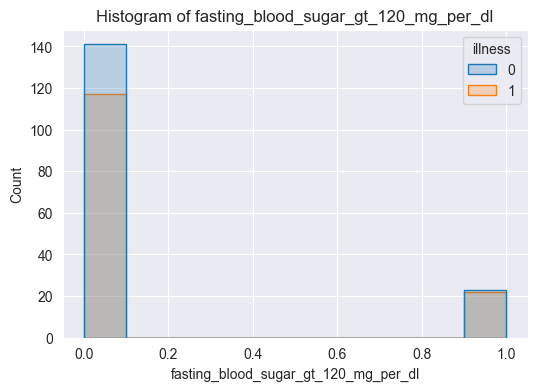

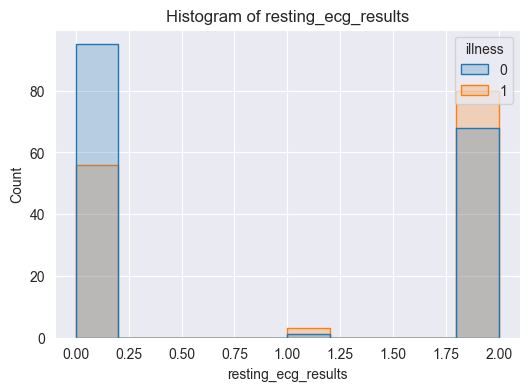

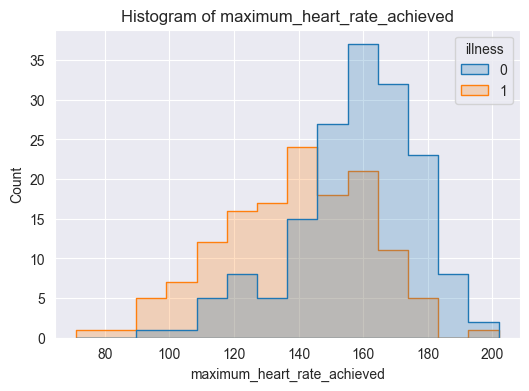

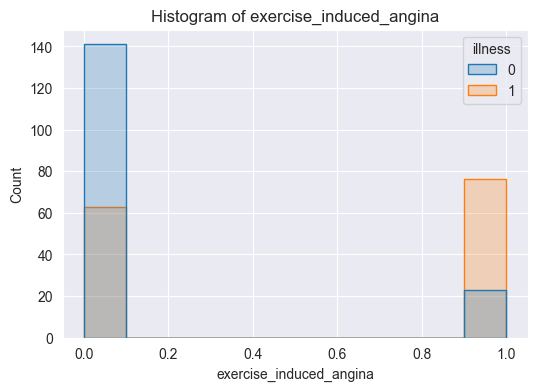

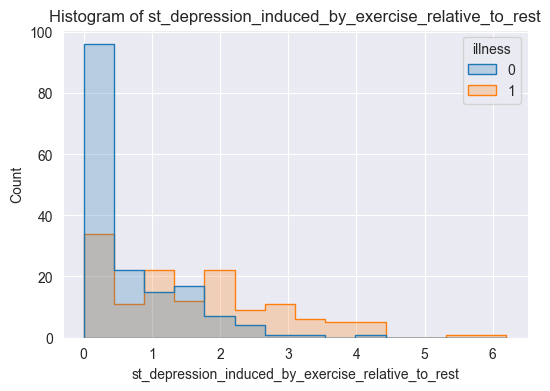

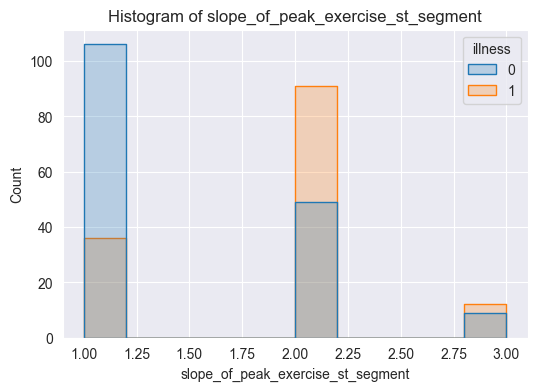

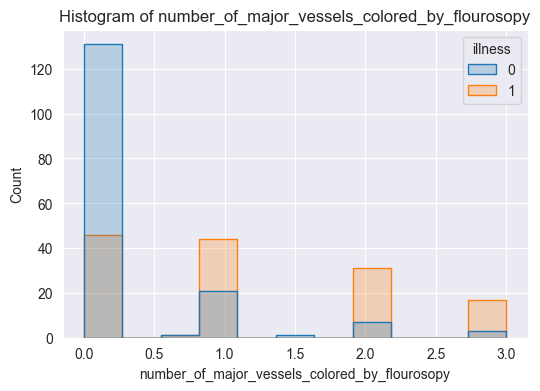

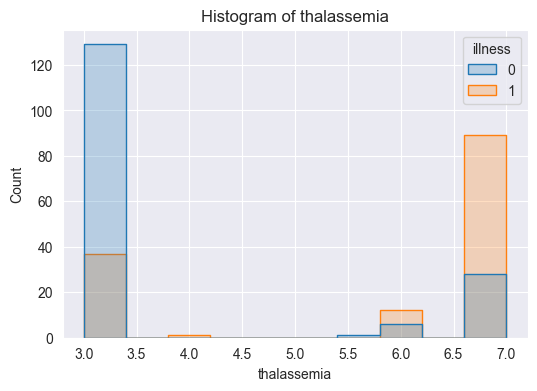

In [16]:
# Create a histogram for each feature
for column in heart_disease_data_imputed.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=complete_data, x=column, hue='illness', element='step')
    plt.title(f'Histogram of {column}')
    plt.show()

## Box Plots
- Box plots will summarize the statistical distribution of each numerical variable.
- Differences in the distributions between the two groups (with and without heart disease) may indicate key factors associated with the disease.


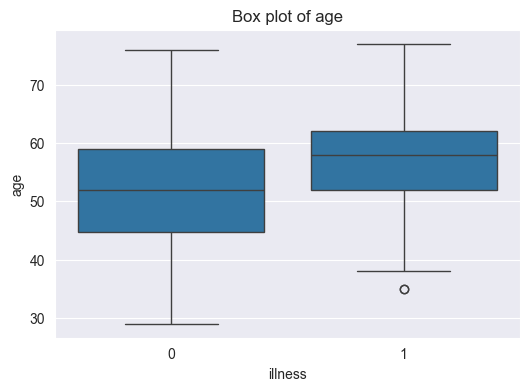

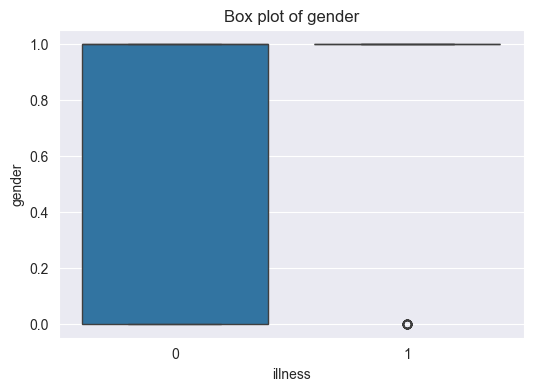

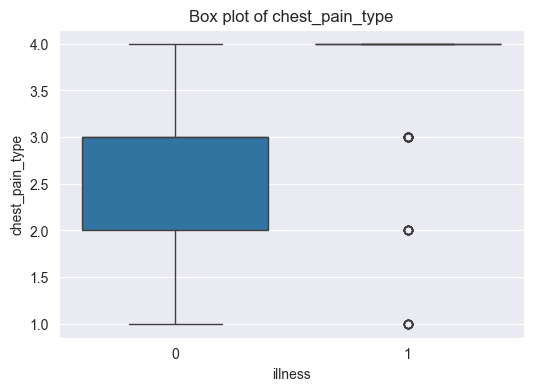

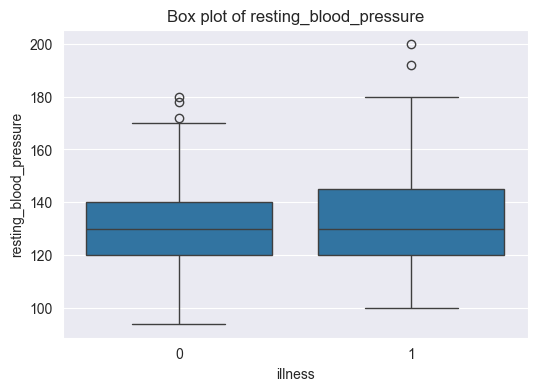

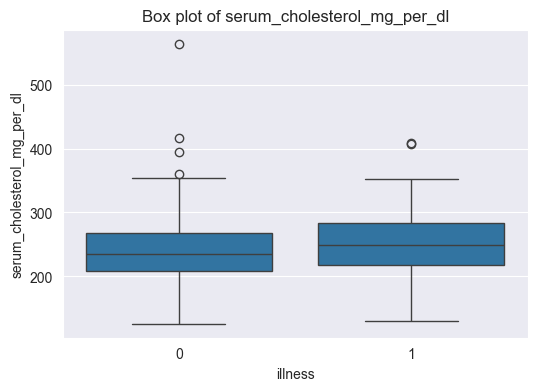

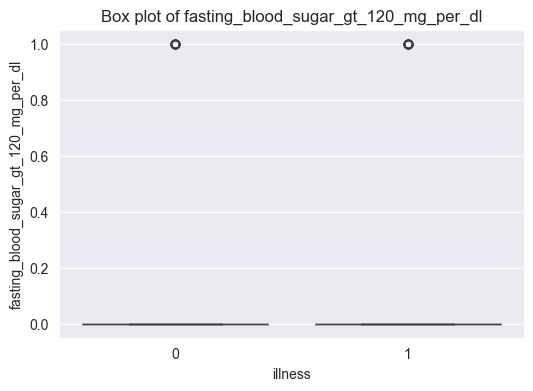

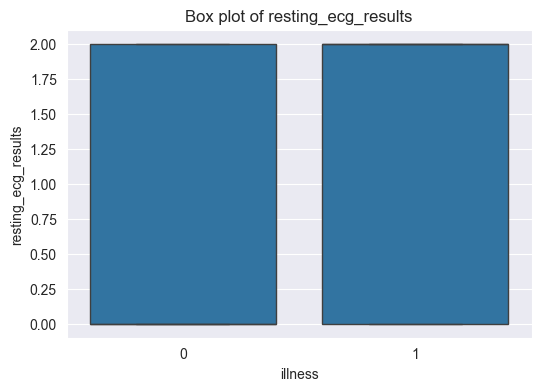

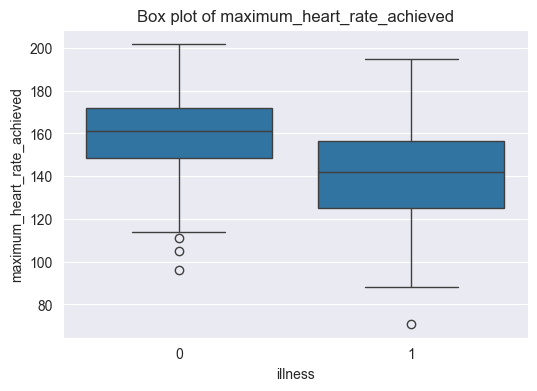

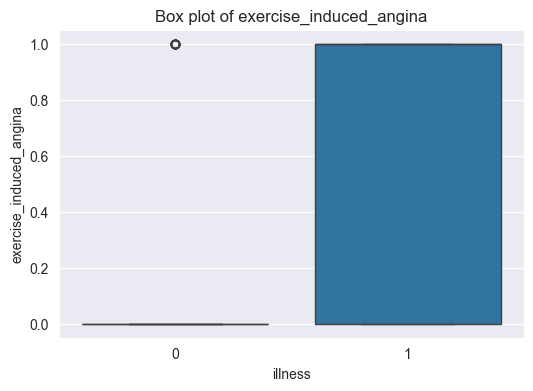

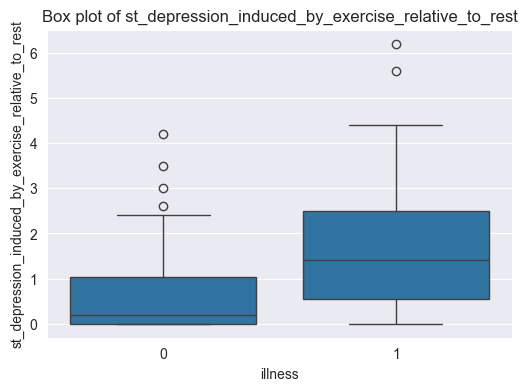

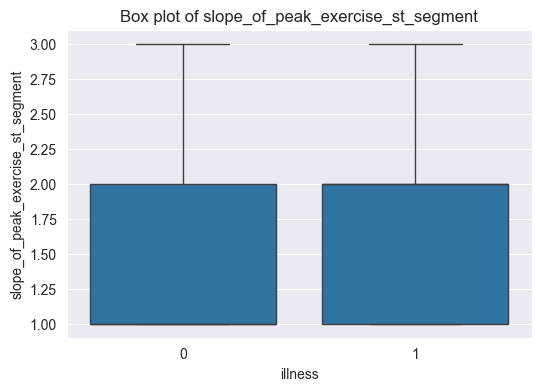

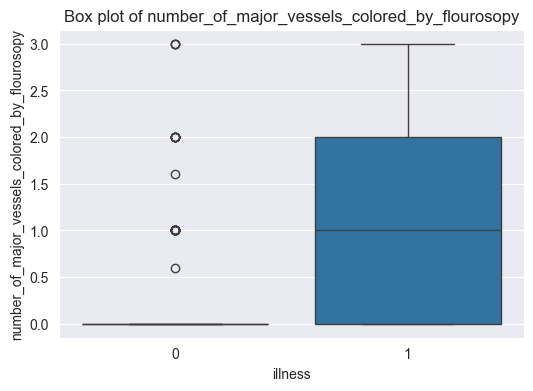

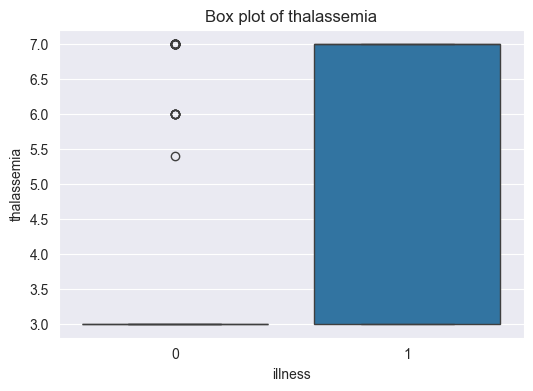

In [17]:
# Create a box plot for each feature
for column in heart_disease_data_imputed.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='illness', y=column, data=complete_data)
    plt.title(f'Box plot of {column}')
    plt.show()

## Pair Plot

The pair plot allows us to see both the distribution of single variables and the relationships between two variables.

### Analysis
- This plot will help in identifying correlations and patterns.
- It will also show how these relationships differ for patients with and against those without heart disease.

### Observations
-Through the pair pairplot and the scatter plots, we can see that the age is a key factor in the heart disease. The older the patient is, the more likely he is to have a heart disease. However, there is no clear disctinction between the two groups accross all the plots.
-This is logical, because in real life there are always edge cases. For example, a young person can have a heart disease because of a genetic disease. Or an old person can be in good health and not have a heart disease.
-Maybe if the dataset was bigger, we could have seen a clearer distinction between the two groups, as the outliers would have been less significant.

<Figure size 2000x2000 with 0 Axes>

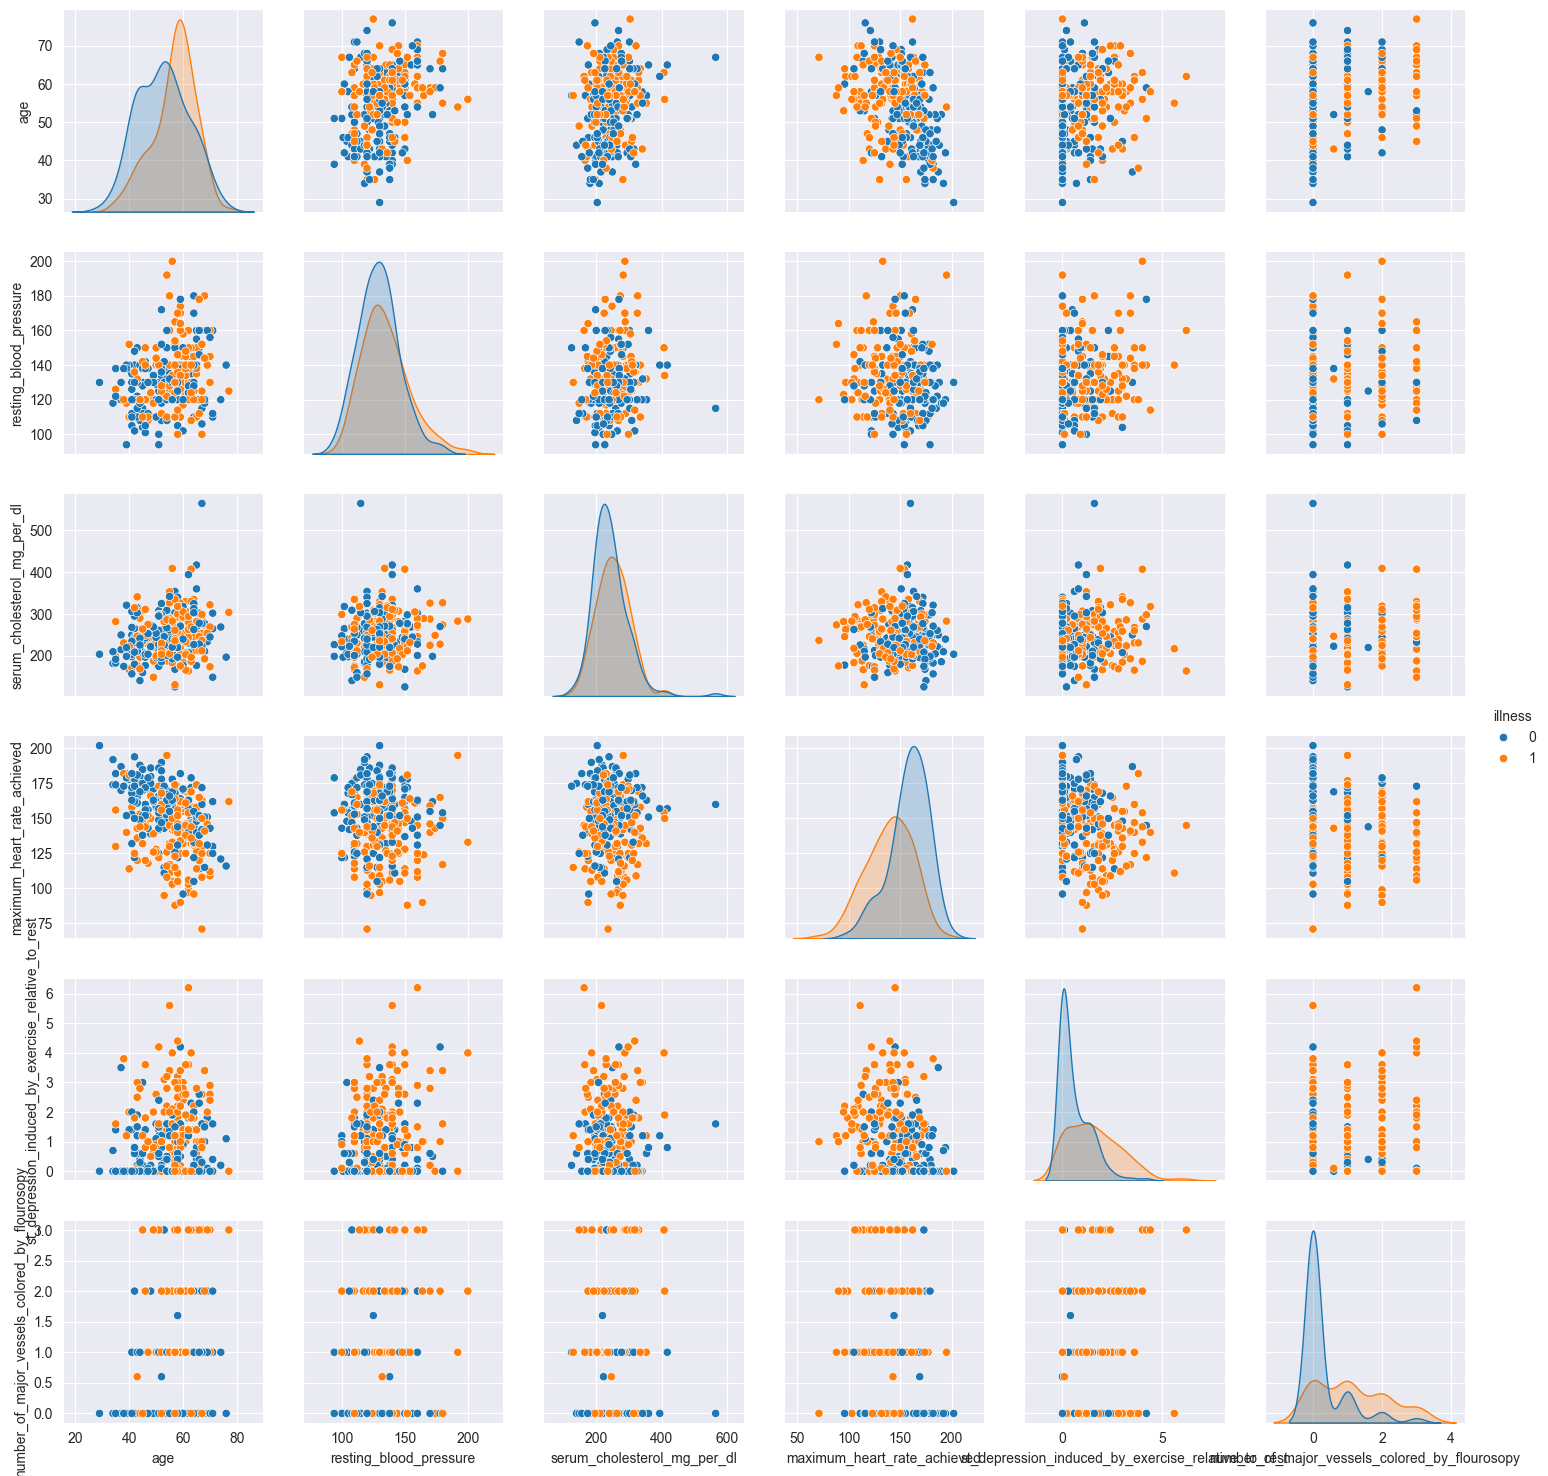

In [18]:
# Create scatter plots for each pair of numeric features 
numerical_cols.append('illness')
plt.figure(figsize=(20, 20))
numscatter = sns.pairplot(complete_data[numerical_cols], hue='illness')
numscatter.fig.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

## Categorical Plots

Finally, we will look at the distribution of categorical variables.

### Analysis
- These plots are essential for understanding the frequency of each category in relation to heart disease.
- It helps in identifying if certain categories have a higher occurrence of the disease.

### Observations
- We can see that chest pain type 4 is a key factor in the heart disease. Indeed, the patients with this type of chest pain are more likely to have a heart disease.
- We can also see that the slope of peak exercise ST segment 2 is a key factor in the heart disease. Indeed, the patients with this type of slope are more likely to have a heart disease.
- We cannot express any conclusion based on gender, seeing as there are twice more female in the study than male.This may also be causing a bias in the results.

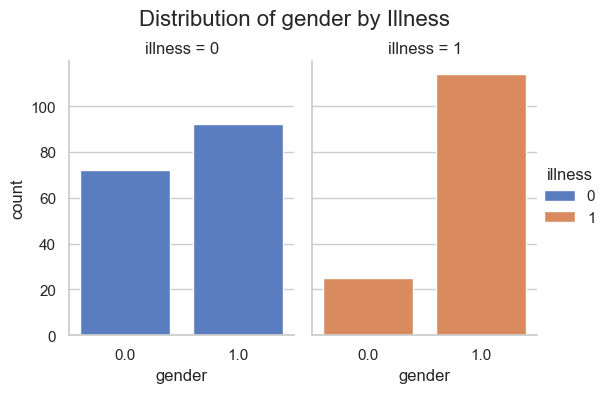

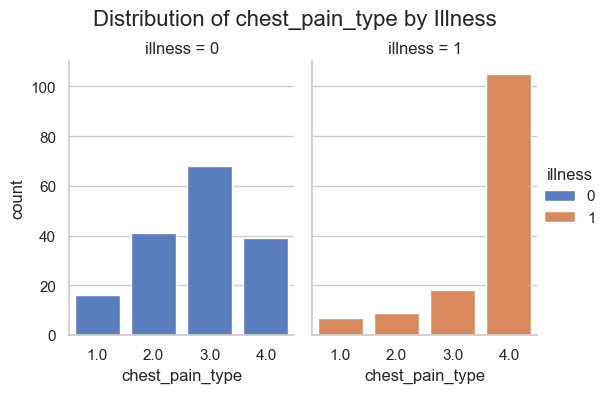

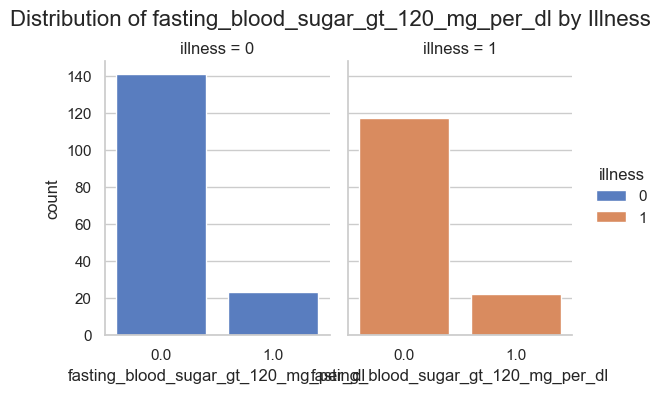

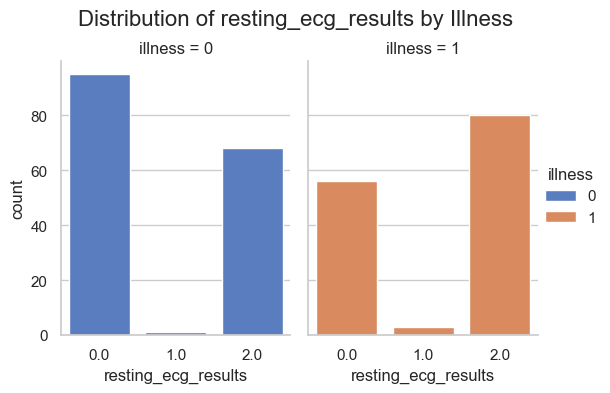

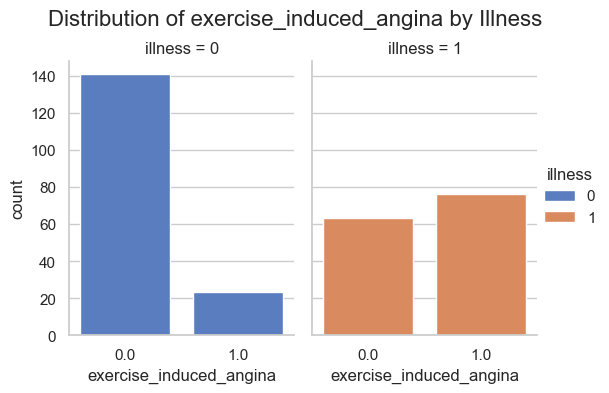

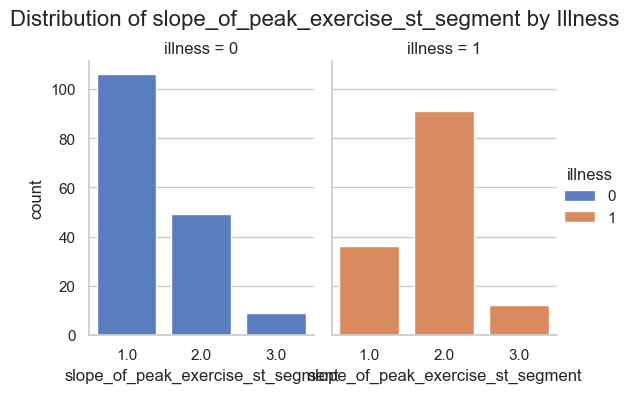

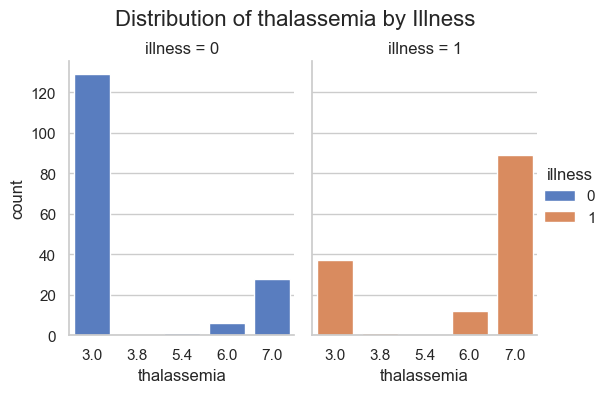

In [19]:
sns.set(style="whitegrid", palette="muted")

# Loop through combinations of the categorical features and create catplots
for i, var in enumerate(categorical_cols):
    g = sns.catplot(x=var, hue="illness", col="illness",
                    data=complete_data, kind="count",
                    height=4, aspect=.7)

    # Set titles and adjust layout for better readability
    g.fig.suptitle(f'Distribution of {var} by Illness', fontsize=16)
    plt.subplots_adjust(top=0.85)

# Show the plots
plt.show()

## Modeling

In [20]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(heart_disease_data_preprocessed, target, test_size=0.3, random_state=20)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((212, 27), (91, 27), (212,), (91,))

## Random Forest

For the Random Forest model:
Accuracy on Training data:  100.0
Accuracy on Test data:  81.31868131868131


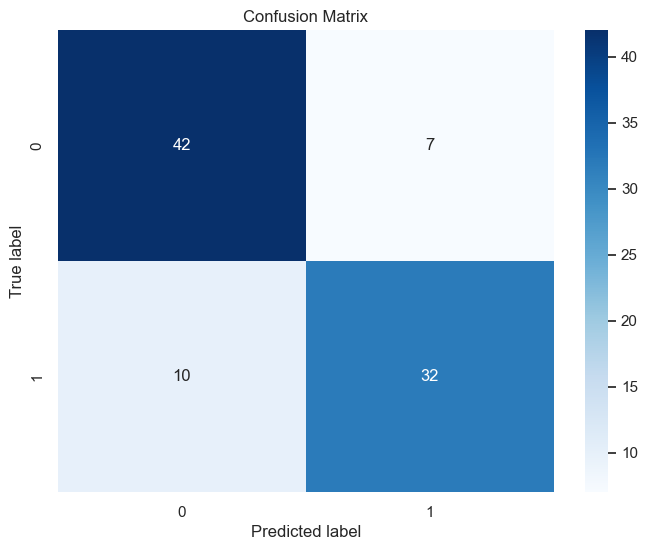

In [22]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    # Add other parameters here
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Accuracy on training data
print("For the Random Forest model:")
X_train_prediction_random_forest = best_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_random_forest,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)

# Accuracy on test data
y_pred_random_forest = best_model.predict(X_test)
accuracy = accuracy_score(y_pred_random_forest, y_test)
print(f"Accuracy on Test data: ",accuracy*100)

#Confussion matrix
RF_conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
plt.figure(figsize=(8, 6))
sns.heatmap(RF_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Logistic Regression

Accuracy on Training data:  86.32075471698113
Accuracy on Test data:  83.51648351648352


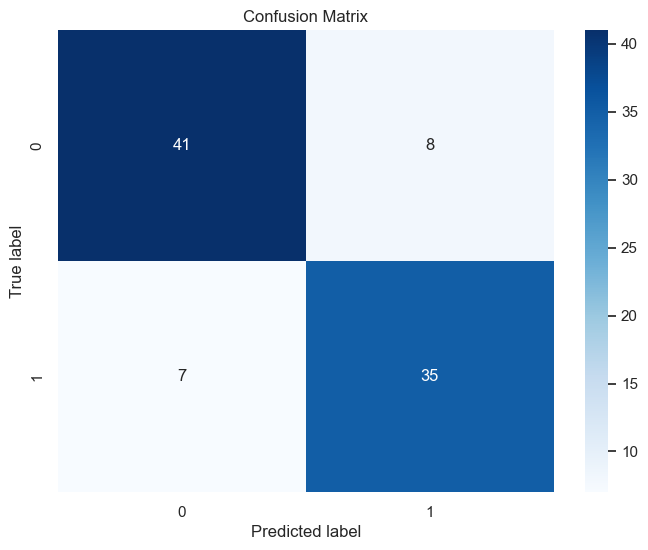

In [24]:
# Initialize the classifier
lr_model = LogisticRegression(solver="liblinear",random_state=2 )

# training the model with training data
lr_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_LR = lr_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_LR,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_LR = lr_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_LR, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
LR_conf_matrix = confusion_matrix(y_test, X_test_prediction_LR)
plt.figure(figsize=(8, 6))
sns.heatmap(LR_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## XGBoost

C:\Users\alexs\PycharmProjects\PfDa_Project_S7\venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Accuracy on Training data:  100.0
Accuracy on Test data:  78.02197802197803


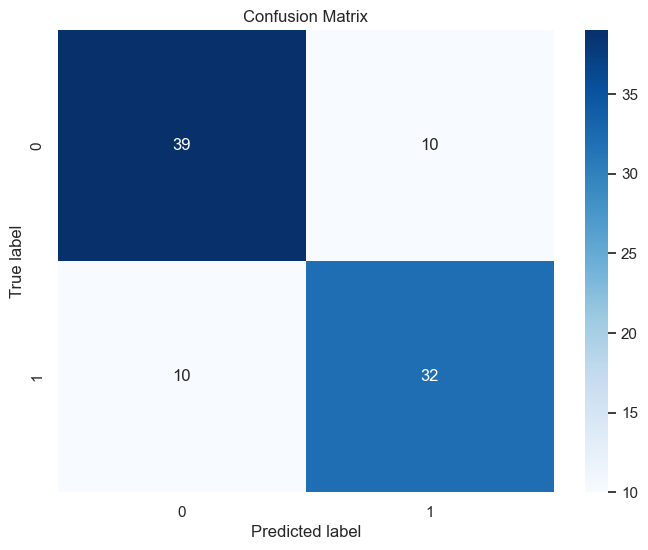

In [25]:
# Initialize the classifier
xgb_model = xgb.XGBClassifier(objective="reg:linear", random_state=42)

# training the model with training data
xgb_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_XGB = xgb_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_XGB,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_XGB = xgb_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_XGB, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
XGB_conf_matrix = confusion_matrix(y_test, X_test_prediction_XGB)
plt.figure(figsize=(8, 6))
sns.heatmap(XGB_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



## Support Vector Classifier

Accuracy on Training data:  91.50943396226415
Accuracy on Test data:  84.61538461538461


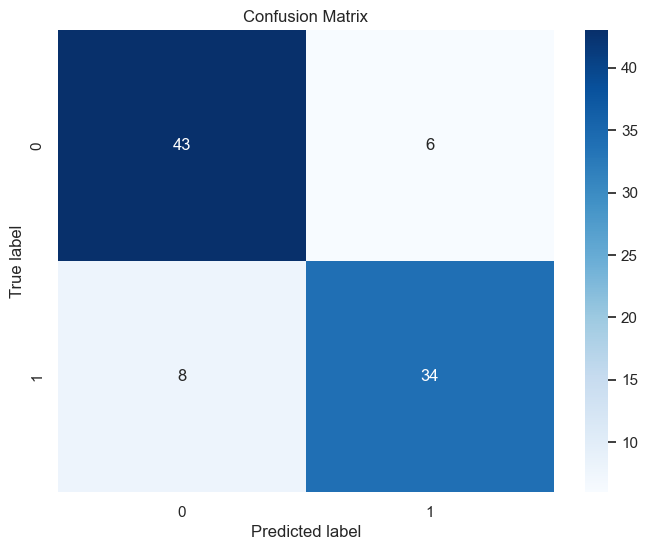

In [26]:
# Initialize the classifier
svc_model = SVC(random_state=20 )

# training the model with training data
svc_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction_SVC = svc_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_SVC,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction_SVC = svc_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_SVC, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
SVC_conf_matrix = confusion_matrix(y_test, X_test_prediction_SVC)
plt.figure(figsize=(8, 6))
sns.heatmap(SVC_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Neural Network CLassifier

Epoch 1/10
6/6 [==============================] - 1s 39ms/step - loss: 0.7145 - accuracy: 0.4368 - val_loss: 0.6460 - val_accuracy: 0.6364
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 0.6321 - accuracy: 0.7368 - val_loss: 0.5921 - val_accuracy: 0.7727
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 0.5638 - accuracy: 0.8105 - val_loss: 0.5440 - val_accuracy: 0.7273
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 0.5098 - accuracy: 0.8211 - val_loss: 0.5044 - val_accuracy: 0.7273
Epoch 5/10
6/6 [==============================] - 0s 7ms/step - loss: 0.4553 - accuracy: 0.8368 - val_loss: 0.4720 - val_accuracy: 0.7273
Epoch 6/10
6/6 [==============================] - 0s 7ms/step - loss: 0.4120 - accuracy: 0.8474 - val_loss: 0.4500 - val_accuracy: 0.6818
Epoch 7/10
6/6 [==============================] - 0s 7ms/step - loss: 0.3758 - accuracy: 0.8474 - val_loss: 0.4392 - val_accuracy: 0.6818
Epoch 8/10
6/6 [=================

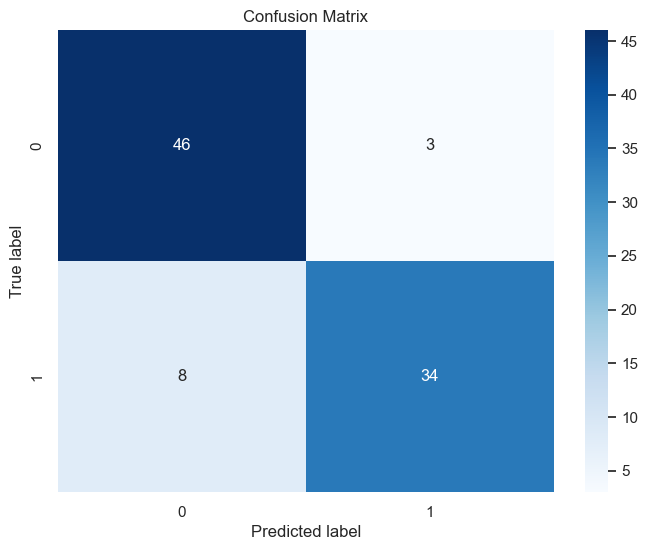

In [27]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# Define the model
NNC = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 'sigmoid' for binary classification
])

# Compile the model
NNC.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
NNC.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predictions
y_pred_NNC = NNC.predict(X_test)
y_pred_NNC = np.round(y_pred_NNC).flatten()  # Convert probabilities to binary predictions

# Accuracy
accuracy = accuracy_score(y_test, y_pred_NNC)
print(f"Accuracy on Test data: ",accuracy*100)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_NNC)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Comparisons between models

*Classification Reports*

In [28]:
# Generate classification reports for each model
reports = {
    'Random Forest': classification_report(y_test, y_pred_random_forest, output_dict=True),
    'Logistic Regression': classification_report(y_test, X_test_prediction_LR, output_dict=True),
    'XGBoost': classification_report(y_test, X_test_prediction_XGB, output_dict=True),
    'Support Vector Classifier': classification_report(y_test, X_test_prediction_SVC, output_dict=True),
    'Neural Network Classifier': classification_report(y_test, y_pred_NNC, output_dict=True)
}

In [29]:
# Convert to DataFrame for a tabular view
df_reports = pd.DataFrame(reports).T  # Transpose to get models as rows
df_reports.index.name = 'Model'
df_reports.reset_index(inplace=True)

In [30]:
df_accuracy = df_reports[['Model', 'accuracy']]
df_macro_avg = df_reports[['Model', 'macro avg']]
df_weighted_avg = df_reports[['Model', 'weighted avg']]


In [31]:
df_not_ill = df_reports[['Model', '0']].copy()

# Then use the .loc method to avoid the SettingWithCopyWarning
df_not_ill.loc[:, 'Precision'] = df_not_ill['0'].apply(lambda x: x['precision'])
df_not_ill.loc[:, 'Recall'] = df_not_ill['0'].apply(lambda x: x['recall'])
df_not_ill.loc[:, 'F1-Score'] = df_not_ill['0'].apply(lambda x: x['f1-score'])

# Now you can safely drop the '0' column if you wish
df_not_ill = df_not_ill.drop('0', axis=1)

print("Dataframe with precision, recall and f1-score for class 0 (not ill)")
df_not_ill.head()

Dataframe with precision, recall and f1-score for class 0 (not ill)


,Model,Precision,Recall,F1-Score
0,Random Forest,0.807692,0.857143,0.831683
1,Logistic Regression,0.854167,0.836735,0.845361
2,XGBoost,0.795918,0.795918,0.795918
3,Support Vector Classifier,0.843137,0.877551,0.860000
4,Neural Network Classifier,0.851852,0.938776,0.893204


In [32]:
df_ill = df_reports[['Model', '1']].copy()

# Then use the .loc method to avoid the SettingWithCopyWarning
df_ill.loc[:, 'Precision'] = df_ill['1'].apply(lambda x: x['precision'])
df_ill.loc[:, 'Recall'] = df_ill['1'].apply(lambda x: x['recall'])
df_ill.loc[:, 'F1-Score'] = df_ill['1'].apply(lambda x: x['f1-score'])

# Now you can safely drop the '0' column if you wish
df_ill = df_ill.drop('1', axis=1)

print("Dataframe with precision, recall and f1-score for class 1 (ill)")
df_ill.head()

Dataframe with precision, recall and f1-score for class 1 (ill)


,Model,Precision,Recall,F1-Score
0,Random Forest,0.820513,0.761905,0.790123
1,Logistic Regression,0.813953,0.833333,0.823529
2,XGBoost,0.761905,0.761905,0.761905
3,Support Vector Classifier,0.850000,0.809524,0.829268
4,Neural Network Classifier,0.918919,0.809524,0.860759


In [33]:
df_weighted_avg = df_reports[['Model', 'weighted avg']].copy()

df_weighted_avg.loc[:, 'Precision'] = df_weighted_avg['weighted avg'].apply(lambda x: x['precision'])
df_weighted_avg.loc[:, 'Recall'] = df_weighted_avg['weighted avg'].apply(lambda x: x['recall'])
df_weighted_avg.loc[:, 'F1-Score'] = df_weighted_avg['weighted avg'].apply(lambda x: x['f1-score'])

df_weighted_avg = df_weighted_avg.drop('weighted avg', axis=1)

print("Dataframe with precision, recall and f1-score for weighted average")
df_weighted_avg.head()

Dataframe with precision, recall and f1-score for weighted average


,Model,Precision,Recall,F1-Score
0,Random Forest,0.813609,0.813187,0.812502
1,Logistic Regression,0.835607,0.835165,0.835285
2,XGBoost,0.780220,0.780220,0.780220
3,Support Vector Classifier,0.846305,0.846154,0.845816
4,Neural Network Classifier,0.882806,0.879121,0.878230


*Visual comparison*

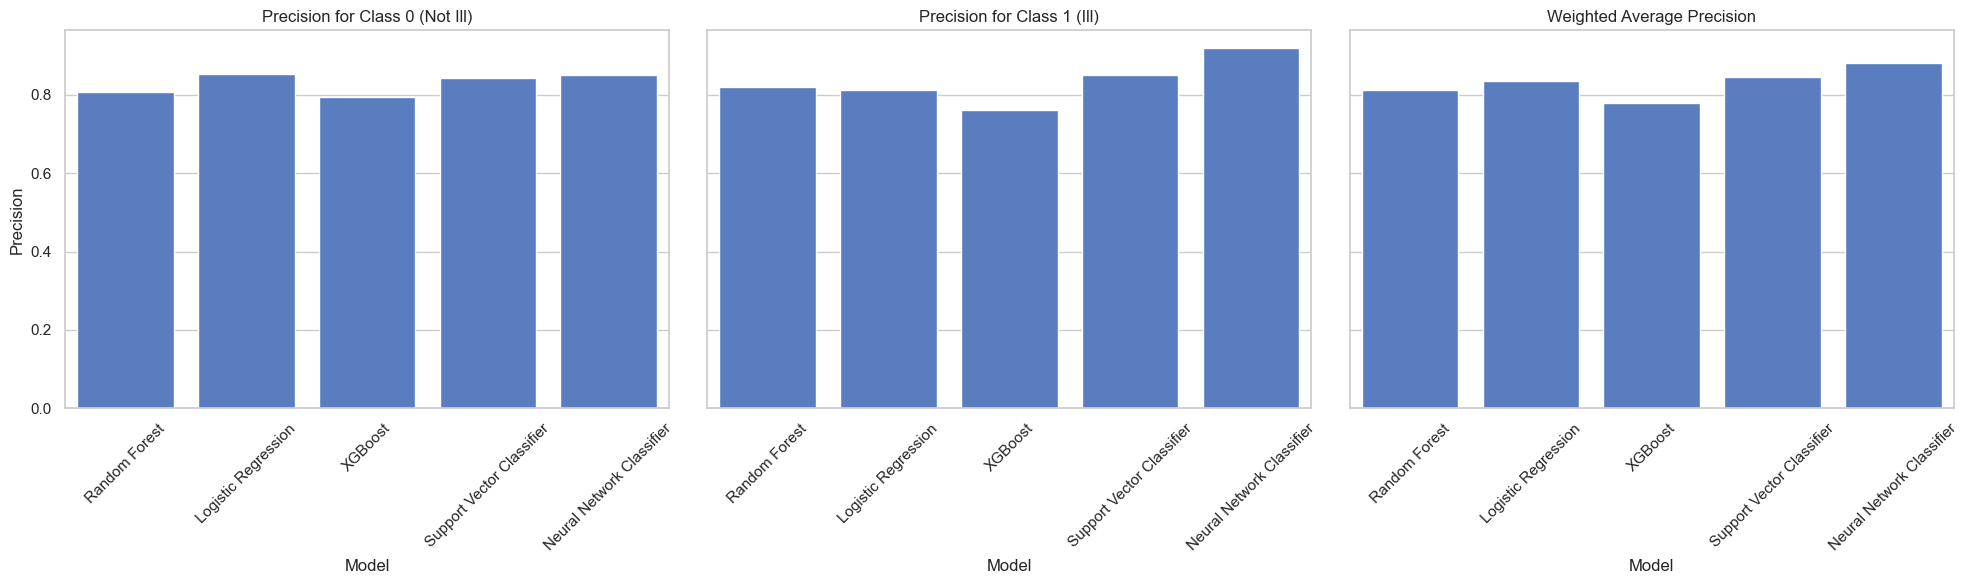

In [34]:
# Now that you have the metrics in separate columns, you can create bar charts
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Precision for "not ill" class
sns.barplot(ax=axes[0], x='Model', y='Precision', data=df_not_ill)
axes[0].set_title('Precision for Class 0 (Not Ill)')
axes[0].tick_params(axis='x', rotation=45)

# Precision for "ill" class
sns.barplot(ax=axes[1], x='Model', y='Precision', data=df_ill)
axes[1].set_title('Precision for Class 1 (Ill)')
axes[1].tick_params(axis='x', rotation=45)

# Precision for weighted average
sns.barplot(ax=axes[2], x='Model', y='Precision', data=df_weighted_avg)
axes[2].set_title('Weighted Average Precision')
axes[2].tick_params(axis='x', rotation=45)

# Final layout settings
plt.tight_layout()
plt.show()


*Conclusion*
After looking at the classification reports and the bar charts, we can conclude that the Neural Network model is the best model for this dataset. It has the highest accuracy, precision, recall, and F1-score. It also has the highest precision for both classes and the highest weighted average precision.
This result is not surprising since Neural Networks are known to perform well on complex datasets. However, it is important to note that the SVC model is a close second. It has the highest recall for both classes and the highest weighted average recall. It also has the highest recall for the "ill" class. This means that the SVC model is better at identifying patients with heart disease. This is a very important task since it is better to be safe than sorry when it comes to heart disease.


However based on the run, the best model may vary. Sometime sit may be the logistic regression, sometimes the SVC or the Neural Network. It is important to run the code several times to see which model is the best. 

But through my observation, the NNC and SVC are the most stable ones and get the best results most of the time.

In [35]:
dump(svc_model, 'SVC.joblib') 

['SVC.joblib']